In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 生成不均衡数据集，少数类分布在中心圆形区域，多数类侵入少数类区域
def generate_sparse_data_with_overlap(n_samples=300, imbalance_ratio=0.3, noise_level=0.4):
    np.random.seed()
    n_majority = int(n_samples * (1 - imbalance_ratio))
    n_minority = n_samples - n_majority

    # 生成少数类：集中分布在中心圆形区域
    radius_minority = np.random.uniform(0, 1.5, size=n_minority)
    angle_minority = np.random.uniform(0, 2 * np.pi, size=n_minority)
    minority_x = np.vstack([radius_minority * np.cos(angle_minority), radius_minority * np.sin(angle_minority)]).T
    
    # 为少数类添加噪声
    noise_minority = np.random.normal(scale=noise_level, size=minority_x.shape)
    minority_x += noise_minority

    # 生成多数类：主要分布在外围区域，但一部分侵入中心区域
    majority_x = []
    while len(majority_x) < n_majority:
        x, y = np.random.uniform(-5, 5, size=2)
        distance_to_center = np.sqrt(x**2 + y**2)
        if distance_to_center > 2.0 or np.random.rand() < 0.1:  # 10%概率放置在中心圆内
            majority_x.append([x, y])
    majority_x = np.array(majority_x)

    # 为多数类添加轻微噪声
    noise_majority = np.random.normal(scale=noise_level, size=majority_x.shape)
    majority_x += noise_majority
    
    # 合并数据集
    X = np.vstack([majority_x, minority_x])
    y = np.hstack([np.zeros(len(majority_x)), np.ones(len(minority_x))])
    return X, y

# 生成原始数据集
X, y = generate_sparse_data_with_overlap(n_samples=200, imbalance_ratio=0.1, noise_level=0.4)

# 选择一个靠近少数类区域的多数类样本
# 使用K近邻查找少数类样本的中心
minority_indices = np.where(y == 1)[0]
minority_samples = X[minority_indices]

# 找出靠近少数类样本的多数类样本
majority_indices = np.where(y == 0)[0]
majority_samples = X[majority_indices]

# 使用K近邻找到少数类中心最近的多数类样本
nbrs = NearestNeighbors(n_neighbors=1).fit(minority_samples)
distances, indices = nbrs.kneighbors(majority_samples)

# 找到距离最小的多数类样本
target_index = np.argmin(distances)
target_sample = majority_samples[target_index].reshape(1, -1)

# 保存原始数据集和目标样本到 .npy 文件
np.save("X_original.npy", X)
np.save("y_original.npy", y)
np.save("target_sample.npy", target_sample)

print("数据保存完成：")
print("X_original.npy：原始数据集的特征")
print("y_original.npy：原始数据集的标签")
print("target_sample.npy：靠近少数类区域的多数类样本坐标")


数据保存完成：
X_original.npy：原始数据集的特征
y_original.npy：原始数据集的标签
target_sample.npy：靠近少数类区域的多数类样本坐标


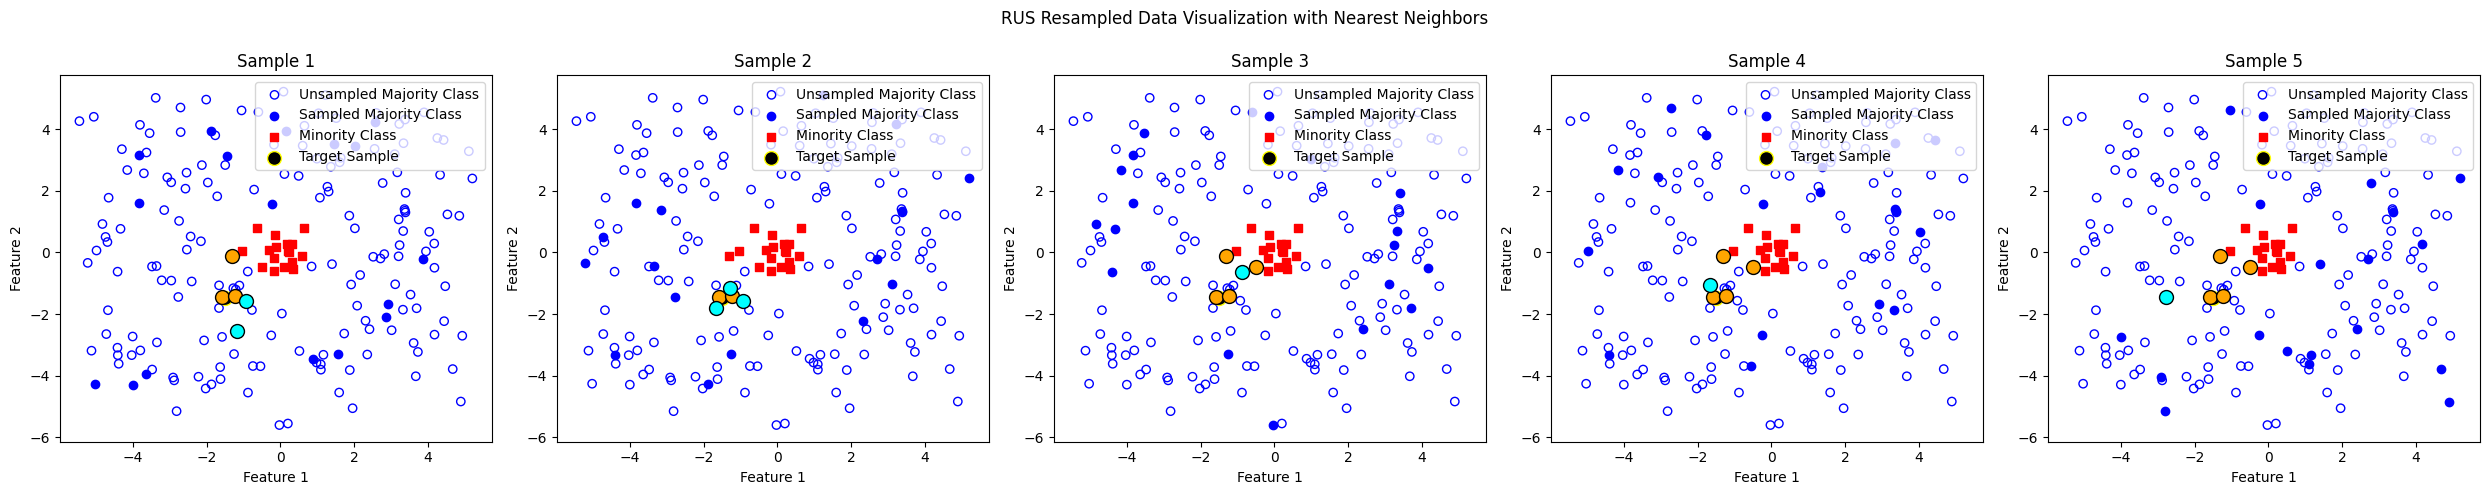

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import RandomUnderSampler

# 加载保存的数据
X_loaded = np.load("X_original.npy")
y_loaded = np.load("y_original.npy")
target_loaded = np.load("target_sample.npy")

# 开始采样并绘图
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 创建5个子图
fig.suptitle("RUS Resampled Data Visualization with Nearest Neighbors")

for i, ax in enumerate(axes):
    # 确保目标样本存在于下采样数据集中
    found_target = False
    while not found_target:
        rus = RandomUnderSampler(random_state=None)  # 每次随机重采样
        X_resampled, y_resampled = rus.fit_resample(X_loaded, y_loaded)

        # 检查目标样本是否在下采样后的数据集中
        if any(np.all(X_resampled == target_loaded, axis=1)):
            found_target = True

    # 标记采样到和未采样到的多数类样本
    majority_indices = np.where(y_loaded == 0)[0]
    resampled_majority_indices = np.where(y_resampled == 0)[0]
    X_majority = X_loaded[majority_indices]

    resampled_majority_points = X_resampled[resampled_majority_indices]
    unsampled_majority_points = np.array([point for point in X_majority if not any(np.all(point == resampled_majority_points, axis=1))])

    # 使用K近邻找出5个最近邻样本
    nbrs = NearestNeighbors(n_neighbors=6).fit(X_resampled)
    distances, indices = nbrs.kneighbors(target_loaded)

    # 提取5个最近邻样本的坐标及类别
    nearest_points = X_resampled[indices[0][1:]]  # 排除自身
    nearest_labels = y_resampled[indices[0][1:]]

    # 绘制子图
    ax.set_title(f"Sample {i + 1}")

    # 多数类：空心蓝色（未采样到）
    ax.scatter(unsampled_majority_points[:, 0], unsampled_majority_points[:, 1],
               color='blue', edgecolor='blue', facecolors='none', label="Unsampled Majority Class")

    # 多数类：实心蓝色（采样到）
    ax.scatter(resampled_majority_points[:, 0], resampled_majority_points[:, 1],
               color='blue', edgecolor='blue', label="Sampled Majority Class")

    # 少数类：红色实心方块
    ax.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1],
               color='red', marker='s', label="Minority Class")

    # 标记目标样本
    ax.scatter(target_loaded[:, 0], target_loaded[:, 1], color='black', s=100,
               label="Target Sample", edgecolor='yellow')

    # 标记5个最近邻样本，根据类别区分颜色
    for point, label in zip(nearest_points, nearest_labels):
        if label == 0:  # 多数类
            ax.scatter(point[0], point[1], color='cyan', edgecolor='black', s=100)
        else:  # 少数类
            ax.scatter(point[0], point[1], color='orange', edgecolor='black', s=100)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend(loc="upper right")

# 调整子图布局
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


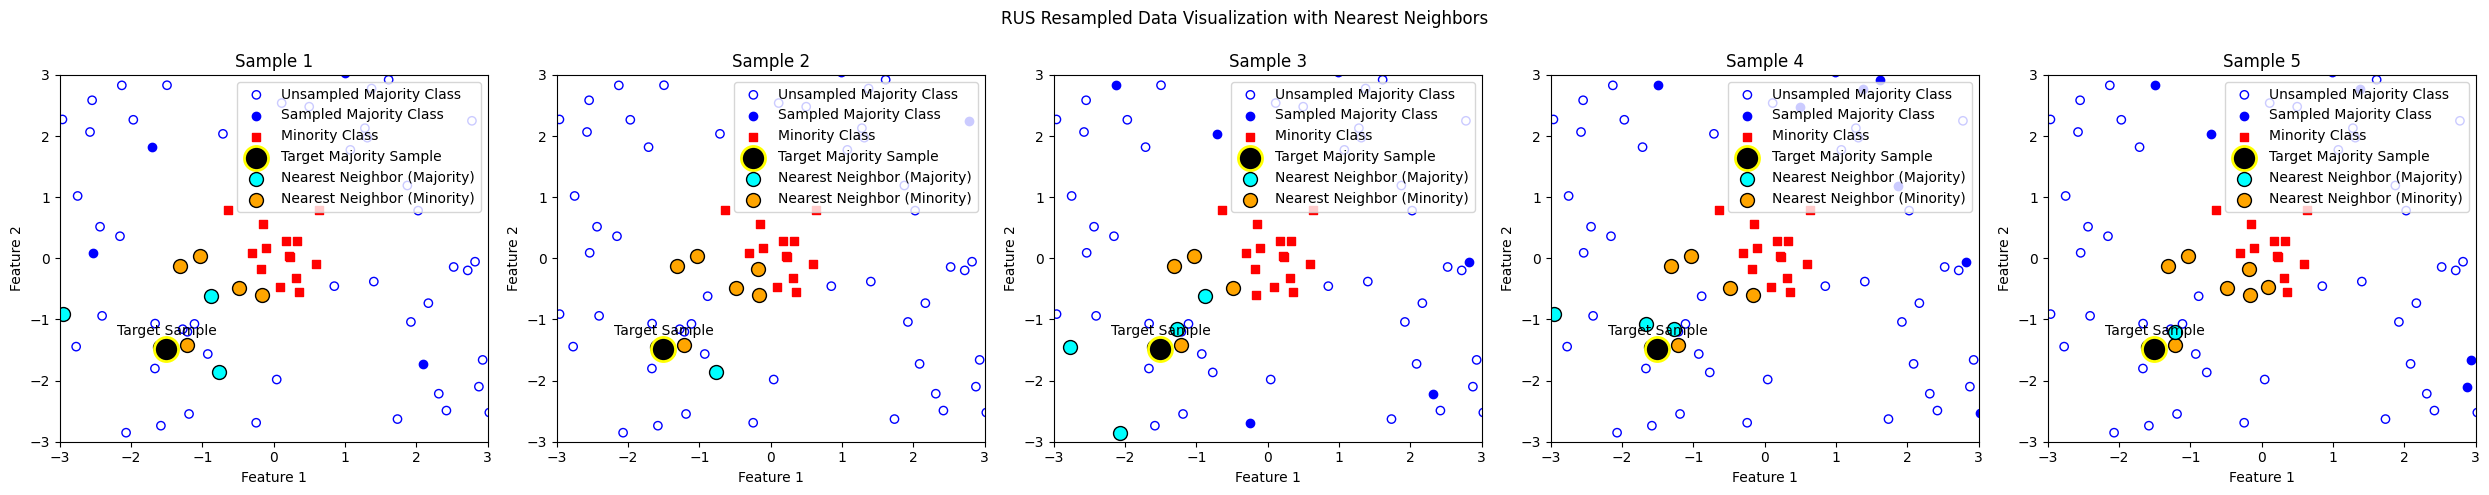

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import RandomUnderSampler

# 加载保存的数据
X_loaded = np.load("X_original.npy")
y_loaded = np.load("y_original.npy")
target_loaded = np.load("target_sample.npy")

# 开始采样并绘图
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 创建5个子图
fig.suptitle("RUS Resampled Data Visualization with Nearest Neighbors")

for i, ax in enumerate(axes):
    # 确保目标样本存在于下采样数据集中
    found_target = False
    while not found_target:
        rus = RandomUnderSampler(random_state=None)  # 每次随机重采样
        X_resampled, y_resampled = rus.fit_resample(X_loaded, y_loaded)

        # 检查目标样本是否在下采样后的数据集中
        if any(np.all(X_resampled == target_loaded, axis=1)):
            found_target = True

    # 标记采样到和未采样到的多数类样本
    majority_indices = np.where(y_loaded == 0)[0]
    resampled_majority_indices = np.where(y_resampled == 0)[0]
    X_majority = X_loaded[majority_indices]

    resampled_majority_points = X_resampled[resampled_majority_indices]
    unsampled_majority_points = np.array([point for point in X_majority if not any(np.all(point == resampled_majority_points, axis=1))])

    # 使用K近邻找出5个最近邻样本
    nbrs = NearestNeighbors(n_neighbors=10).fit(X_resampled)
    distances, indices = nbrs.kneighbors(target_loaded)

    # 提取5个最近邻样本的坐标及类别
    nearest_points = X_resampled[indices[0][1:]]  # 排除自身
    nearest_labels = y_resampled[indices[0][1:]]

    # 绘制子图
    ax.set_title(f"Sample {i + 1}")

    # 多数类：空心蓝色（未采样到）
    ax.scatter(unsampled_majority_points[:, 0], unsampled_majority_points[:, 1],
               color='blue', edgecolor='blue', facecolors='none', label="Unsampled Majority Class")

    # 多数类：实心蓝色（采样到）
    ax.scatter(resampled_majority_points[:, 0], resampled_majority_points[:, 1],
               color='blue', edgecolor='blue', label="Sampled Majority Class")

    # 少数类：红色实心方块
    ax.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1],
               color='red', marker='s', label="Minority Class")

    # 标记目标样本（增大大小 + 特殊颜色 + 添加箭头）
    ax.scatter(target_loaded[:, 0], target_loaded[:, 1], color='black', s=300, 
               label="Target Majority Sample", edgecolor='yellow', linewidth=2, zorder=5)
    ax.annotate("Target Sample", (target_loaded[0, 0], target_loaded[0, 1]), 
                textcoords="offset points", xytext=(0, 10), ha='center', 
                arrowprops=dict(facecolor='yellow', arrowstyle="->"))

    # 标记5个最近邻样本
    nearest_majority = ax.scatter([], [], color='cyan', edgecolor='black', s=100, label="Nearest Neighbor (Majority)")
    nearest_minority = ax.scatter([], [], color='orange', edgecolor='black', s=100, label="Nearest Neighbor (Minority)")

    for point, label in zip(nearest_points, nearest_labels):
        if label == 0:  # 多数类
            ax.scatter(point[0], point[1], color='cyan', edgecolor='black', s=100)
        else:  # 少数类
            ax.scatter(point[0], point[1], color='orange', edgecolor='black', s=100)

    # 设置坐标轴的范围为 [-8, 8]
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    # 添加完整图例
    ax.legend(loc="upper right")

# 调整子图布局
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


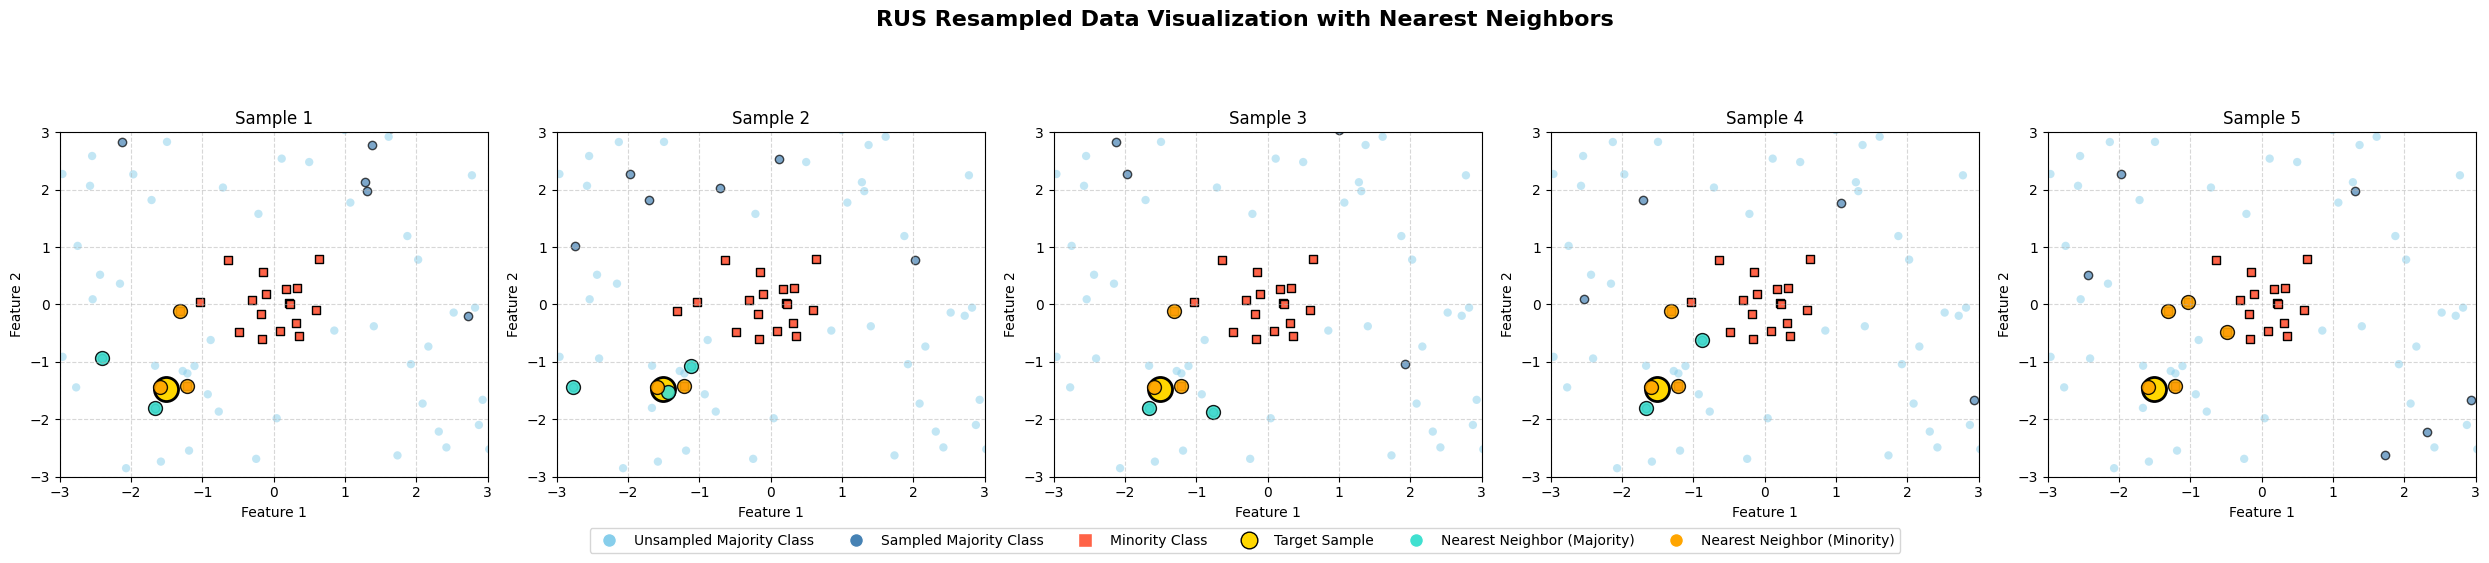

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from imblearn.under_sampling import RandomUnderSampler

# 加载保存的数据
X_loaded = np.load("X_original.npy")
y_loaded = np.load("y_original.npy")
target_loaded = np.load("target_sample.npy")

# 开始采样并绘图
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 创建5个子图
fig.suptitle("RUS Resampled Data Visualization with Nearest Neighbors", fontsize=16, fontweight='bold', y=1.05)

# 定义颜色
colors = {
    "unsampled_majority": "#87CEEB",  # 天蓝色
    "sampled_majority": "#4682B4",    # 深蓝色
    "minority_class": "#FF6347",      # 番茄红
    "target_sample": "#FFD700",       # 金黄色
    "nearest_majority": "#40E0D0",    # 绿松石色
    "nearest_minority": "#FFA500"     # 橙色
}

for i, ax in enumerate(axes):
    # 确保目标样本存在于下采样数据集中
    found_target = False
    while not found_target:
        rus = RandomUnderSampler(random_state=None)
        X_resampled, y_resampled = rus.fit_resample(X_loaded, y_loaded)
        if any(np.all(X_resampled == target_loaded, axis=1)):
            found_target = True

    # 标记采样到和未采样到的多数类样本
    majority_indices = np.where(y_loaded == 0)[0]
    resampled_majority_indices = np.where(y_resampled == 0)[0]
    X_majority = X_loaded[majority_indices]

    resampled_majority_points = X_resampled[resampled_majority_indices]
    unsampled_majority_points = np.array([point for point in X_majority if not any(np.all(point == resampled_majority_points, axis=1))])

    # 使用K近邻找出5个最近邻样本
    nbrs = NearestNeighbors(n_neighbors=6).fit(X_resampled)
    distances, indices = nbrs.kneighbors(target_loaded)
    nearest_points = X_resampled[indices[0][1:]]
    nearest_labels = y_resampled[indices[0][1:]]

    # 绘图
    ax.set_title(f"Sample {i + 1}", fontsize=12)

    # 多数类：未采样
    ax.scatter(unsampled_majority_points[:, 0], unsampled_majority_points[:, 1],
               color=colors['unsampled_majority'], edgecolor='none', alpha=0.5, label="Unsampled Majority Class")

    # 多数类：采样
    ax.scatter(resampled_majority_points[:, 0], resampled_majority_points[:, 1],
               color=colors['sampled_majority'], edgecolor='black', alpha=0.7, label="Sampled Majority Class")

    # 少数类
    ax.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1],
               color=colors['minority_class'], marker='s', edgecolor='black', label="Minority Class")

    # 目标样本
    ax.scatter(target_loaded[:, 0], target_loaded[:, 1], color=colors['target_sample'], 
               s=300, edgecolor='black', linewidth=2, label="Target Sample")

    # 最近邻
    for point, label in zip(nearest_points, nearest_labels):
        if label == 0:  # 多数类
            ax.scatter(point[0], point[1], color=colors['nearest_majority'], edgecolor='black', s=100, alpha=0.9)
        else:  # 少数类
            ax.scatter(point[0], point[1], color=colors['nearest_minority'], edgecolor='black', s=100, alpha=0.9)

    # 设置范围和网格线
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel("Feature 1", fontsize=10)
    ax.set_ylabel("Feature 2", fontsize=10)

# 显式添加图例中的最近邻点
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['unsampled_majority'], markersize=10, label='Unsampled Majority Class'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['sampled_majority'], markersize=10, label='Sampled Majority Class'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['minority_class'], markersize=10, label='Minority Class'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['target_sample'], markersize=12, markeredgecolor='black', label='Target Sample'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['nearest_majority'], markersize=10, label='Nearest Neighbor (Majority)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['nearest_minority'], markersize=10, label='Nearest Neighbor (Minority)')
]

# 图例放置在底部
fig.legend(handles=legend_handles, loc='lower center', ncol=6, fontsize=10, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
